In [1]:
# DATASET  : https://www.cis.fordham.edu/wisdm/dataset.php
# WISDM_ar_v1.1_raw.txt

In [38]:
from pandas import read_csv, unique

import numpy as np
import pandas as pd
import tensorflow as tf

from scipy.interpolate import interp1d
from scipy.stats import mode
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from tensorflow.keras.layers import Conv1D, Flatten, Reshape, MaxPooling1D, LayerNormalization, Add
from keras.layers import Conv1D, LSTM, Dropout
from tensorflow.keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from keras.layers import Input
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [23]:
names = ["user_id", "activity", "timestamp", "x_axis", "y_axis", "z_axis", "NaN"]
data = pd.read_csv("D:/HAR/WISDM/WISDM_ar_v1.1_raw.txt", header=None, names=names, comment=";")

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

df = data.drop('NaN', axis=1)
df["z_axis"].replace(regex = True, inplace = True, to_replace = r';', value = r'')
    # ... and then this column must be transformed to float explicitly
df["z_axis"] = df["z_axis"].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss will show up as NAN
df.dropna(axis=0, how='any', inplace=True)
df.head()
print(df.shape)

(1098203, 6)


In [24]:
mapping = {'Walking': 0, 'Jogging': 1, 'Upstairs': 2, 'Downstairs': 3, 'Sitting': 4, 'Standing': 5}

# 레이블 인코딩
df['ActivityEncoded'] = df['activity'].map(mapping)
df

,user_id,activity,timestamp,x_axis,y_axis,z_axis,ActivityEncoded
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,1
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,1
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,1
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,1
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,1
...,...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,9.000000,-1.570000,1.690000,4
1098200,19,Sitting,131623371431000,9.040000,-1.460000,1.730000,4
1098201,19,Sitting,131623411592000,9.080000,-1.380000,1.690000,4
1098202,19,Sitting,131623491487000,9.000000,-1.460000,1.730000,4


<Axes: xlabel='activity', ylabel='count'>

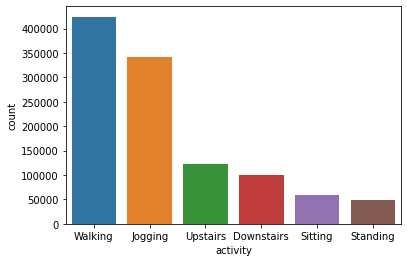

In [25]:
sns.countplot(x = "activity", data = df, order = df.activity.value_counts().index)

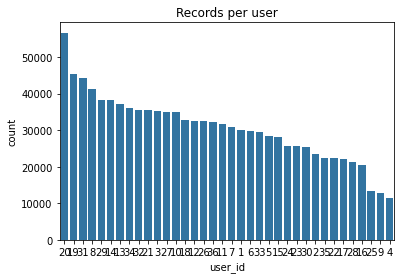

In [26]:
sns.countplot(x = "user_id", data = df, palette = [sns.color_palette()[0]],
              order = df.user_id.value_counts().index)
plt.title("Records per user");

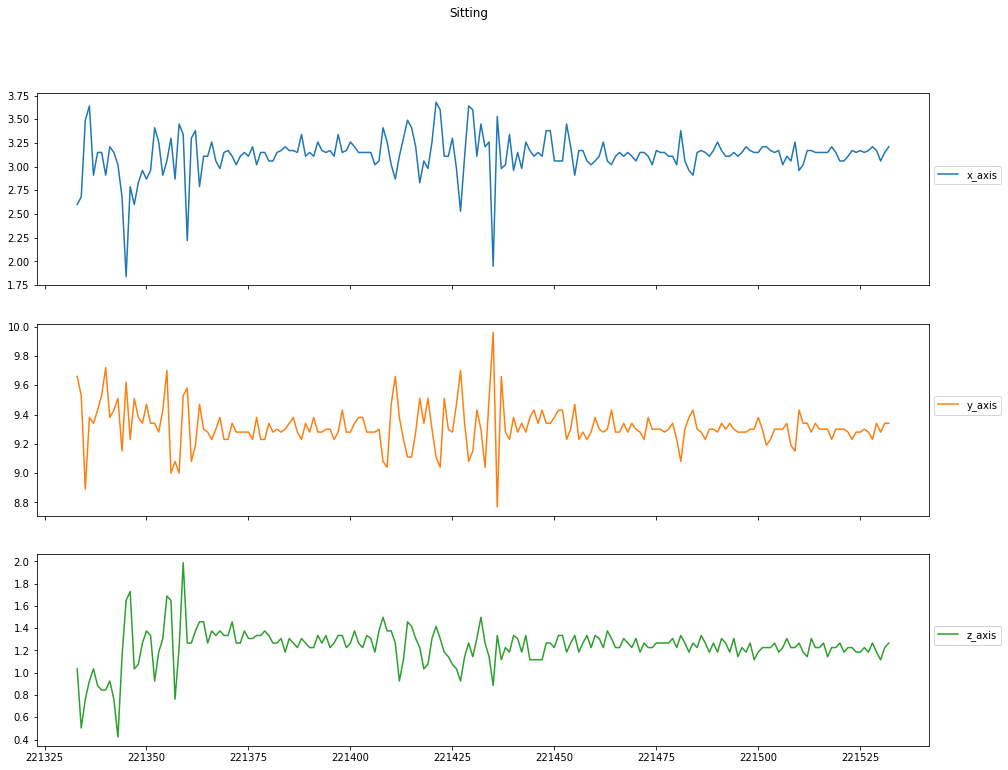

In [27]:
def plot_activity(activity, df):
    data = df[df["activity"] == activity][["x_axis", "y_axis", "z_axis"]][:200]
    axis = data.plot(subplots = True, figsize = (16, 12), title = activity)
    for ax in axis:
        ax.legend(loc = "lower left", bbox_to_anchor = (1.0, 0.5))

plot_activity("Sitting", df)

In [28]:
from sklearn.preprocessing import RobustScaler

scale_columns = ["x_axis", "y_axis", "z_axis"]
scaler = RobustScaler()
scaler = scaler.fit(df[scale_columns])
df.loc[:, scale_columns] = scaler.transform(df[scale_columns].to_numpy())
df

,user_id,activity,timestamp,x_axis,y_axis,z_axis,ActivityEncoded
0,33,Jogging,49105962326000,-0.131961,0.566215,0.102015,1
1,33,Jogging,49106062271000,0.648740,0.397381,0.193001,1
2,33,Jogging,49106112167000,0.633834,0.351926,-0.016543,1
3,33,Jogging,49106222305000,-0.120782,1.259408,0.612089,1
4,33,Jogging,49106332290000,-0.199038,0.498032,1.458535,1
...,...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,1.194254,-1.132300,0.342105,4
1098200,19,Sitting,131623371431000,1.199726,-1.119190,0.350202,4
1098201,19,Sitting,131623411592000,1.205198,-1.109654,0.342105,4
1098202,19,Sitting,131623491487000,1.194254,-1.119190,0.350202,4


In [29]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 200
STEP = 40

X_data, y_data = create_dataset(df[["x_axis", "y_axis", "z_axis"]], df.ActivityEncoded, TIME_STEPS,
                                  STEP)

X_train, X_test,y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, stratify=  y_data )
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size = 0.2, stratify=  y_train )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(17568, 200, 3) (17568, 1)
(5491, 200, 3) (5491, 1)


In [30]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown = "ignore", sparse = False)
enc = enc.fit(y_train)

y_train_hot = enc.transform(y_train)
y_test_hot = enc.transform(y_test)
y_val_hot = enc.transform(y_val)

print(X_train.shape, y_train_hot.shape, X_test.shape, y_test_hot.shape)

(17568, 200, 3) (17568, 6) (5491, 200, 3) (5491, 6)


In [31]:
#Epoch 500

BATCH_SIZE = 32

verbose,epochs,batch_size=1,10, BATCH_SIZE

n_timesteps,n_features,n_outputs= X_train.shape[1],X_train.shape[2],y_train_hot.shape[1]
n_timesteps,n_features,n_outputs

(200, 3, 6)

In [32]:
def SE_Block(inputs, num_filters, ratio):
    squeeze = tf.keras.layers.GlobalAveragePooling1D()(inputs)

    excitation = tf.keras.layers.Dense(units=num_filters/ratio)(squeeze)
    excitation = tf.keras.layers.Activation('relu')(excitation)
    excitation = tf.keras.layers.Dense(units=num_filters)(excitation)
    excitation = tf.keras.layers.Activation('sigmoid')(excitation)
    excitation = tf.keras.layers.Reshape([1, num_filters])(excitation)

    scale = inputs * excitation

    return scale

In [33]:
def Conv_1D_Block(inputs, num_filters, kernel, strides):
    # 1D Convolutional Block with BatchNormalization
    x = tf.keras.layers.Conv1D(num_filters, kernel, strides=strides, padding="same", kernel_initializer="he_normal")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    return x

In [34]:
def residual_block(inputs, num_filters, ratio):
    # Construct a Residual Block of Convolutions
    # x        : input into the block
    # n_filters: number of filters
    shortcut = inputs
    #
    conv = Conv_1D_Block(inputs, num_filters, 3, 1)
    conv = Conv_1D_Block(conv, num_filters, 3, 1)
    conv = SE_Block(conv, num_filters, ratio)
    conv = tf.keras.layers.Add()([conv, shortcut])
    out = tf.keras.layers.Activation('relu')(conv)

    return out

In [50]:
def ResBlock(inputs, num_units):
    x = Dense(num_units, activation='relu')(inputs)  
    x = Dense(num_units, activation='relu')(x)  
    res = Add()([x, inputs])
    return res

# CNN Model

In [51]:
num_filters = 3
ratio = 1
num_units = 3

inputs= Input(shape=(n_timesteps,n_features))

residual_output = ResBlock(inputs, num_units)
conv1  = Conv1D(filters=64, kernel_size=3, activation='relu')(residual_output)

x = Flatten()(conv1)
x = Dense(128, activation='relu')(x)
outputs = Dense(n_outputs, activation='softmax')(x)

model = Model(inputs, outputs) 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 200, 3)]             0         []                            
                                                                                                  
 dense_10 (Dense)            (None, 200, 3)               12        ['input_10[0][0]']            
                                                                                                  
 dense_11 (Dense)            (None, 200, 3)               12        ['dense_10[0][0]']            
                                                                                                  
 add_4 (Add)                 (None, 200, 3)               0         ['dense_11[0][0]',            
                                                                     'input_10[0][0]']      

In [52]:
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 200, 3)]             0         []                            
                                                                                                  
 dense_10 (Dense)            (None, 200, 3)               12        ['input_10[0][0]']            
                                                                                                  
 dense_11 (Dense)            (None, 200, 3)               12        ['dense_10[0][0]']            
                                                                                                  
 add_4 (Add)                 (None, 200, 3)               0         ['dense_11[0][0]',            
                                                                     'input_10[0][0]']      

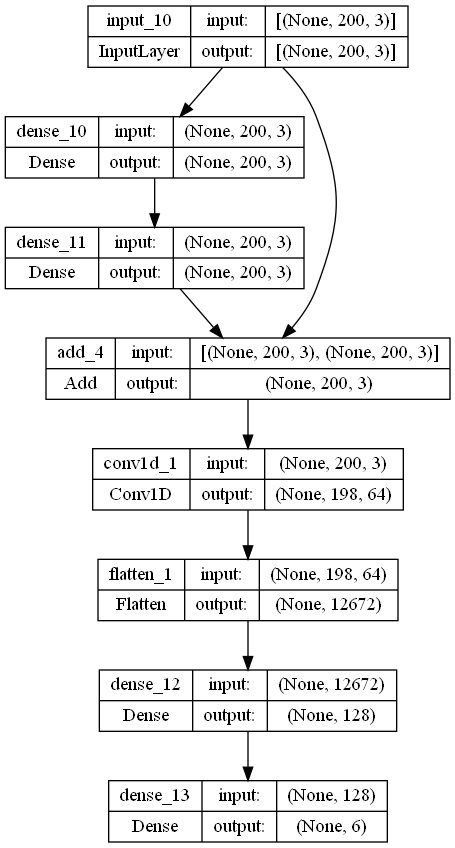

In [53]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_shapes.png', show_shapes=True)

In [ ]:
validation_split = 0.1
history = model.fit(X_train, y_train_hot, batch_size= 192, epochs=20, verbose=True,  validation_split=validation_split)

Epoch 1/20
83/83 [==============================] - 6s 60ms/step - loss: 0.9702 - accuracy: 0.6512 - val_loss: 0.6557 - val_accuracy: 0.7587
Epoch 2/20
83/83 [==============================] - 5s 56ms/step - loss: 0.5166 - accuracy: 0.8159 - val_loss: 0.4740 - val_accuracy: 0.8224
Epoch 3/20
83/83 [==============================] - 5s 55ms/step - loss: 0.3664 - accuracy: 0.8690 - val_loss: 0.4089 - val_accuracy: 0.8589
Epoch 4/20
83/83 [==============================] - 5s 54ms/step - loss: 0.2739 - accuracy: 0.9066 - val_loss: 0.4229 - val_accuracy: 0.8367
Epoch 5/20
83/83 [==============================] - 5s 55ms/step - loss: 0.2191 - accuracy: 0.9270 - val_loss: 0.3730 - val_accuracy: 0.8731
Epoch 6/20
83/83 [==============================] - 4s 54ms/step - loss: 0.1679 - accuracy: 0.9495 - val_loss: 0.4049 - val_accuracy: 0.8719
Epoch 7/20
83/83 [==============================] - 5s 55ms/step - loss: 0.1401 - accuracy: 0.9574 - val_loss: 0.3623 - val_accuracy: 0.8793
Epoch 8/20
83

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [ ]:


y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')